#### Character Level Language Model Using Wavenet Architecture Implemented From Scratch in PyTorch
Paper link - https://arxiv.org/pdf/1609.03499

Overview<br>
1. Model takes in `block_size` number of characters as input and predicts the next character
2. Input data is a list of names and output are new names. The data can be replaced with any large enough dataset (~100k tokens).
3. Hyperparameters like `block_size`(context length), `emb_size`(embedding dimensions), `hidden_layer_dim`(hidden layer dimensions) can be tuned to achieve better performance

In [1]:
# import

import torch.nn.functional as F
import requests
import random
import torch
import matplotlib.pyplot as plt

In [2]:
# dataset download

names = requests.get("https://raw.githubusercontent.com/karpathy/makemore/master/names.txt").text.splitlines()

In [3]:
# string to token conversion

itos = ['.'] + sorted(list(set("".join(names))))
stoi = {ch: idx for idx, ch in enumerate(itos)}

In [4]:
# create dataset

def create_data(words, block_size=3):
    xs = []
    ys = []
    for word in words:
        window = [0] * block_size
        word += "."
        for char in word:
            xs.append(window)
            ys.append(stoi[char])

            window = window[1:]
            window.append(stoi[char])
    return torch.tensor(xs), torch.tensor(ys)

In [5]:
# initialize train, val, test datasets

# choose context length
block_size = 8

random.seed(17)
random.shuffle(names)
n1 = int(0.8 * len(names))
n2 = int(0.9 * len(names))
xs, ys = create_data(names, block_size)
x_train, y_train = create_data(names[:n1], block_size)
x_val, y_val = create_data(names[n1:n2], block_size)
x_test, y_test = create_data(names[n2:], block_size)

print("train -", x_train.shape[0])
print("val   -", x_val.shape[0])
print("test  -", x_test.shape[0])
print("total -", xs.shape[0])

train - 182705
val   - 22652
test  - 22789
total - 228146


In [6]:
for x, y in zip(x_train[:20], y_train[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> c
.......c --> a
......ca --> r
.....car --> l
....carl --> o
...carlo --> s
..carlos --> .
........ --> s
.......s --> o
......so --> l
.....sol --> v
....solv --> i
...solvi --> .
........ --> m
.......m --> a
......ma --> t
.....mat --> y
....maty --> l
...matyl --> d
..matyld --> a


In [11]:
# classes initializations

class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.bias = torch.zeros((1, fan_out)) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias == None else [self.bias])


class BatchNorm1D:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps # to avoid division by zero when variance is zero
        self.momentum = momentum # the fraction of running mean and variance to be updated with new batch mean and variance
        self.training = True # bn has different training and inference behaviour

        # trainable parameters (trained with gradient update)
        self.gamma = torch.ones(dim) # scaling parameter, init with ones because it is multiplied with normalized preactivations
        self.beta = torch.zeros(dim) # shifting parameter, init with zeros because it is added with normalized preactivations

        # buffers (trained with a running 'momentum update)
        self.running_mean = torch.zeros(dim) # init with zero because it is subtracted from the preact values
        self.running_var = torch.ones(dim) # init with ones because it is the denominator of the preact values

    def __call__(self, x):
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0, 1)
            xmean = x.mean(dim, keepdim=True)
            xvar = x.var(dim, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to zero mean and unit standard deviation
        self.out = self.gamma * xhat + self.beta

        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar

        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:

    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []


class Embedding:

    def __init__(self, fan_in, fan_out):
        self.W = torch.randn((fan_in, fan_out))

    def __call__(self, x):
        self.out = self.W[x]
        return self.out

    def parameters(self):
        return [self.W]


class Sequential:

    def __init__(self, layers):
        self.layers = layers
        self.parameters = [p for layer in self.layers for p in layer.parameters()]
        for p in self.parameters:
            p.requires_grad = True

    def __call__(self, x):
        # print(list(x.shape), round(x.float().mean().item(), 2), round(x.float().std().item(), 2))
        for layer in self.layers:
            x = layer(x)
            # print(layer.__class__.__name__, "                  ", list(x.shape), "                ", round(x.std().item(), 2))
        self.out = x
        return self.out


class FlattenConsecutive:

    def __init__(self, n):
        self.n = n

    def __call__(self, x):
        B, T, C = x.shape
        self.out = x.view(B, T//self.n, C*self.n)
        if T//self.n == 1:
            self.out = torch.squeeze(self.out, 1)
        return self.out

    def parameters(self):
        return []

In [12]:
# MLP

# for reproducibility
torch.manual_seed(100)

# hyperparameters
n_embd = 10
n_hidden = 100
vocab_size = 27

# model definition
model = Sequential([
    Embedding(vocab_size, n_embd),
    Linear(                           n_embd, n_hidden, bias=False), BatchNorm1D(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(2*n_hidden, n_hidden, bias=False), BatchNorm1D(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(2*n_hidden, n_hidden, bias=False), BatchNorm1D(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(2*n_hidden, n_hidden, bias=False), BatchNorm1D(n_hidden), Tanh(),
    Linear(                         n_hidden, vocab_size, bias=False), BatchNorm1D(vocab_size)
])

# scaling of weights for better gradient propagation
with torch.no_grad():
    model.layers[-1].gamma *= 0.1 # last layer : make less confident
    for layer in model.layers[:-1]: # all other layers : apply gain
        if isinstance(layer, Linear):
            layer.weight *= 5/3

In [13]:
max_steps = 50001
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, x_train.shape[0], (batch_size,))
  Xb, Yb = x_train[ix], y_train[ix] # batch X,Y

  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for layer in model.layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph

  for p in model.parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in model.parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 5000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in model.parameters])

#   if i >= 0:
#     break

      0/  50001: 3.2991
   5000/  50001: 2.1215
  10000/  50001: 1.9385
  15000/  50001: 1.7877
  20000/  50001: 1.9765
  25000/  50001: 1.7431
  30000/  50001: 1.9065
  35000/  50001: 2.2249
  40000/  50001: 1.8934
  45000/  50001: 2.2729
  50000/  50001: 2.5460


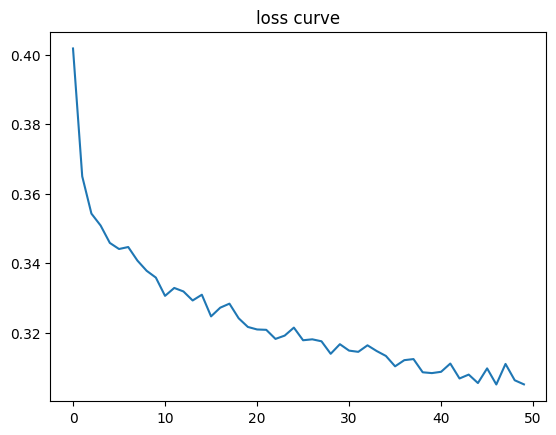

In [24]:
lossi_avg = torch.tensor(lossi[:-1]).view(-1, 1000).mean(1).tolist()
plt.plot(lossi_avg)
plt.title("loss curve");

In [25]:
# evaluation

@torch.no_grad()
def split_loss(split):
    x, y = {
        "all": (xs, ys),
        "train": (x_train, y_train),
        "val": (x_val, y_val),
        "test": (x_test, y_test)
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, "-", loss.item())

split_loss("val")
split_loss("all")

val - 2.082395553588867
all - 2.0053257942199707


In [26]:
# inference

for layer in model.layers:
    if isinstance(layer, BatchNorm1D):
        layer.training = False

with torch.no_grad():
    for i in range(30):
        context = [0] * block_size
        while True:
            logits = model(torch.tensor([context]))
            probs = F.softmax(logits, dim=1)
            ix = torch.multinomial(probs, num_samples=1).item()
            context = context[1:] + [ix]
            print(itos[ix], end="")
            if ix == 0:
                break
        print("")

bladena.
saazuan.
lumander.
jenaanise.
kyinaliz.
saroni.
kashtie.
eleseyoe.
monuel.
masyja.
audatha.
conte.
manaida.
shaphya.
caliniyah.
madonius.
hayton.
leora.
bradon.
kinei.
dingta.
lillen.
keana.
vailee.
eshigaria.
maryek.
samara.
mantalyna.
aliery.
izvy.
